# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
#Загружаем нужные нам библиотеки

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
#Загружаем данные

labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
#Создадим функцию для отображения информации о данных
https://disk.yandex.ru/d/yToviTO_3atULw
def study(data): 
    info = display(data.head(10)), data.info(), display(data.describe())

In [4]:
#Посмотрим на данные

study(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


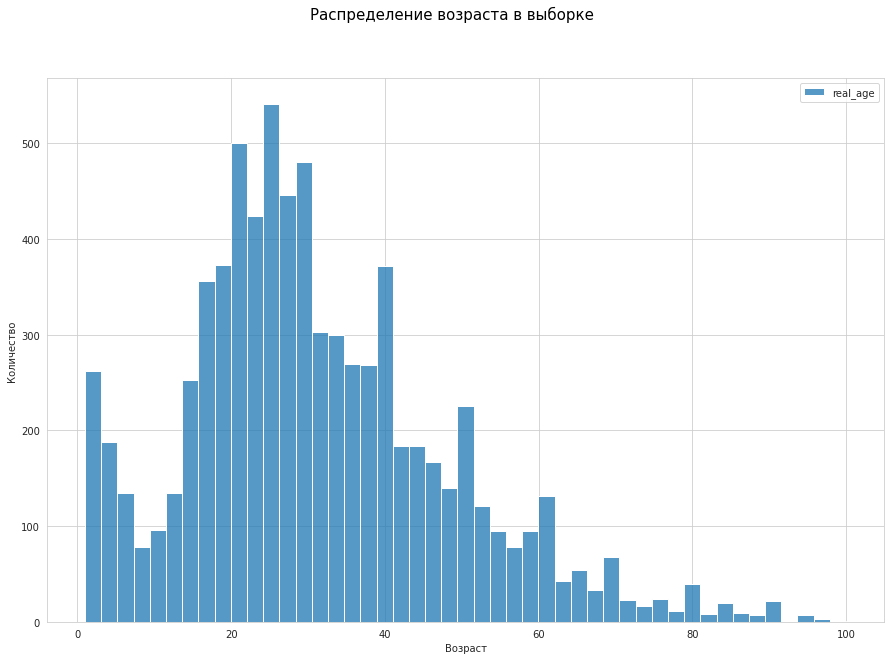

In [5]:
#Построим график распределения возраста в выборке

plt.figure(figsize=[15, 10])
plt.suptitle('Распределение возраста в выборке', fontsize=15)
sns.set_style('whitegrid')
sns.histplot(labels)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show();

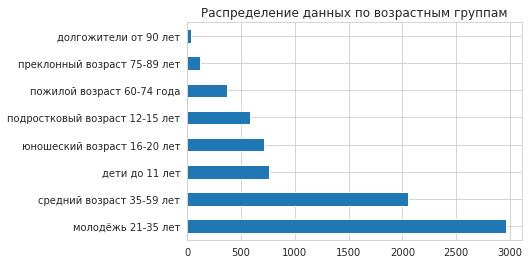

In [6]:
#Разделим возраста на группы(такое разделение было взято из статьи в википедии 'Возрастная периодизация') 

labels['age_group'] = pd.cut(
    labels.real_age,
    bins=[0, 11, 16, 20, 35, 59, 74, 89, 100],
    labels=['дети до 11 лет', 'подростковый возраст 12-15 лет', 'юношеский возраст 16-20 лет',
            'молодёжь 21-35 лет', 'средний возраст 35-59 лет',
            'пожилой возраст 60-74 года', 'преклонный возраст 75-89 лет',
            'долгожители от 90 лет'])

labels.age_group.value_counts().plot(
    kind='barh', grid=True,
    title='Распределение данных по возрастным группам');

Можем заметить, что большее количество фотографий приходится на 2 группы: средний возраст и молодёжь. Распределение имеет нормальную форму, после 41 лет мы видим естественную убыль данных по возрастам. Долгожителей совсем немного, да и эти данные, по моему мнению, нам неособо и не нужны, так как люди такого почтенного возраста вряд ли могут быть активны в сети.

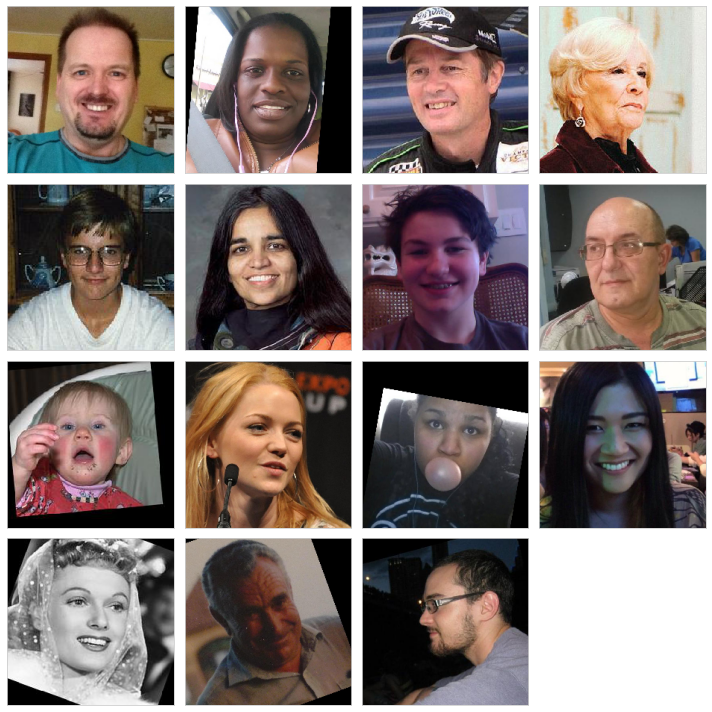

In [7]:
#Напечатаем 15 фотографий из датасета 

features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Ознакомившись с фотографиями из датасета, можем предположить, что не все они будут полезны для обучения. Так как есть фото с затемнением лица, фото, на которых видно только профиль человека, или фото, на которых вещи закрывают лицо, либо у человека сильная эмоция на фото.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

 def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
 
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       validation_split=0.25, 
                                       horizontal_flip=True)
 
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                       directory=path + 'final_files/', 
                                       x_col='file_name', 
                                       y_col='real_age', 
                                       target_size=(224, 224), 
                                       batch_size=16, 
                                       class_mode='raw', 
                                       subset='training', 
                                       seed=12345)
    return train_datagen_flow
 
 
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
 
    test_datagen = ImageDataGenerator(rescale=1./255, 
                                      validation_split=0.25)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels, 
                                       directory=path + 'final_files/', 
                                       x_col='file_name', 
                                       y_col='real_age', 
                                       target_size=(224, 224), 
                                       batch_size=16, 
                                       class_mode='raw', 
                                       subset='validation', 
                                       seed=12345)
    return test_datagen_flow
 
 
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, 
                  loss='mae', 
                  metrics=['mae'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10, 
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model


```

# < скопируйте результат вывода на экран сюда >

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-09-17 19:50:58.666965: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-17 19:50:59.064176: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 54s - loss: 10.5432 - mae: 10.5444 - val_loss: 18.5967 - val_mae: 18.5894
Epoch 2/10
356/356 - 44s - loss: 7.4946 - mae: 7.4951 - val_loss: 9.3261 - val_mae: 9.3243
Epoch 3/10
356/356 - 44s - loss: 6.4999 - mae: 6.5003 - val_loss: 6.7773 - val_mae: 6.7768
Epoch 4/10
356/356 - 44s - loss: 5.8584 - mae: 5.8584 - val_loss: 6.6959 - val_mae: 6.6962
Epoch 5/10
356/356 - 44s - loss: 5.3667 - mae: 5.3672 - val_loss: 7.7267 - val_mae: 7.7307
Epoch 6/10
356/356 - 45s - loss: 5.0078 - mae: 5.0070 - val_loss: 6.6930 - val_mae: 6.7000
Epoch 7/10
356/356 - 45s - loss: 4.5602 - mae: 4.5604 - val_loss: 6.4892 - val_mae: 6.4885
Epoch 8/10
356/356 - 46s - loss: 4.2449 - mae: 4.2453 - val_loss: 7.2291 - val_mae: 7.2390
Epoch 9/10
356/356 - 45s - loss: 4.0161 - mae: 4.0164 - val_loss: 6.5504 - val_mae: 6.5538
Epoch 10/10
356/356 - 46s - loss: 3.7302 - mae: 3.7307 - val_loss: 6.5181 - val_mae: 6.5154

119/119 - 11s - loss: 6.5181 - mae: 6.5154
Test MAE: 6.5154


# < длинные строки со скачиванием модели можно удалить >

```

На тестовой выборке нам удалось достигнуть МАЕ 6.5154. Обучение модели было быстрым, так как данных в выборке было немного. У нас было задано 10 эпох, это оптимальное количество для задачи. Условием был установлен порог МАЕ неболее 8, мы справились с поставленной задачей.

## Анализ обученной модели

В проекте была использована архитектура ResNet50 с одним нейроном(это 1000 классов), выбрали для него активацию ReLU, а также был задействован алгоритм Adam с гиперпараметром learning_rate=0.0001. 

Сеть была предобучена на данных imagenet, благодаря этому мы смогли сократить время на обучение, что позволяет нам уменьшить расходы на вычислительные ресурсы. 

Размер батча был выбран 16, количество эпох 10. 

Сказать о явном переобучении нельзя, но мы видим, как потери сначала сокращались, затем немного увеличивались и снова сокращались. Можем сделать выводы, что модель хорошо усвоила предоставленные ей данные.  

На тестовой выборке нам удалось достигнуть МАЕ 6.5154.

# Вывод

Исследовали данные в датасете. Построили графики для понимания распределения разных возрастов. Количество фотографий в датасете 7591. Предобработка данных не производилась, но для улучшения качества модели можно было бы попробовать это сделать. Большее количество фотографий приходится на 2 группы: средний возраст и молодёжь.

За основу мы взяли архитектуру ResNet50 с одним нейроном, сеть была предобучена на датасете imagenet. Задействовали алгоритм Adam c гиперпараметром learning_rate=0.0001. Размер батча был выбран 16, количество эпох 10.

На тестовой выборке нам удалось достигнуть МАЕ 6.5154. Условием был установлен порог МАЕ неболее 8, нам удалось справиться с поставленной задачей.

